In [2]:
import ast

import pandas as pd
import os
import os.path as osp
from glob import glob
import sys

import seaborn

from const import ID2LABELS, fine2coarse, COARSE_LABEL
# Add the parent directory to the Python path
sys.path.insert(0, '..')
import numpy as np
import torch

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
path_to_root_folder = r'D:\Project-mpg microgesture\mac2024\track1\annotations-20240613T185539Z-001\annotations'
path_to_root_folder = osp.join(*path_to_root_folder.split('/'))

train_data_path = osp.join(path_to_root_folder,'train_list_videos.txt')
val_data_path = osp.join(path_to_root_folder,'val_list_videos.txt')

# train_files_folder = osp.join(path_to_root_folder, 'train')
# val_files_folder = osp.join(path_to_root_folder, 'validation')

In [4]:
df_train_raw = pd.read_csv(train_data_path, sep=' ', header=None)
df_val_raw = pd.read_csv(val_data_path,  sep=' ', header=None)

df_train_raw.columns = ['filename','label']
df_train_raw['dataset'] = 'train'
df_val_raw.columns = ['filename','label']
df_val_raw['dataset'] = 'val'

df = pd.concat([df_train_raw,df_val_raw])
df = df.set_index(['filename','dataset'])


In [5]:
df['label_text'] = df['label'].apply(lambda x: ID2LABELS[x])
df['coarse_label'] = df['label'].apply(lambda x: fine2coarse(x))
df['coarse_label_text'] = df['coarse_label'].apply(lambda x: COARSE_LABEL[x])

df

,,label,label_text,coarse_label,coarse_label_text
filename,dataset,,,,
0003_01_0001.mp4,train,9,nodding,1,head
0003_01_0002.mp4,train,9,nodding,1,head
0003_01_0003.mp4,train,9,nodding,1,head
0003_01_0009.mp4,train,7,tilting head,1,head
0003_01_0011.mp4,train,8,turning head,1,head
...,...,...,...,...,...
0193_05_0006.mp4,val,38,playing or tidying hair,5,head-hand
0193_05_0011.mp4,val,39,scratching or touching hindbrain,5,head-hand
0193_05_0013.mp4,val,47,pushing glasses,5,head-hand


In [6]:
all_labels = list(ID2LABELS.keys())
all_coarse_labels = list(COARSE_LABEL.keys())

all_labels_txt = list(ID2LABELS.values())
all_coarse_labels_txt = list(COARSE_LABEL.values())
comb_labels = all_labels_txt+all_coarse_labels_txt




In [7]:
df.columns

Index(['label', 'label_text', 'coarse_label', 'coarse_label_text'], dtype='object')

In [8]:
"""
i want to create a multi-hot encoding from this.
the labels will represent the first 52 elements (there are 52 labels)
then there will be 4 labels: body, head, hands, legs.
labels 4-5-6 will be encoded as having 1 in both body parts.
in total. there will be 52+4=56 multi-hot labels.
each row will have 2-3 "ones" , representing their label and the involving body parts.
"""

'\ni want to create a multi-hot encoding from this.\nthe labels will represent the first 52 elements (there are 52 labels)\nthen there will be 4 labels: body, head, hands, legs.\nlabels 4-5-6 will be encoded as having 1 in both body parts.\nin total. there will be 52+4=56 multi-hot labels.\neach row will have 2-3 "ones" , representing their label and the involving body parts.\n'

In [9]:
# Define the number of labels and body parts
num_labels = len(all_labels)
num_body_parts = 4
total_length = num_labels + num_body_parts

# Define the mapping for body parts
body_parts_mapping = {
    0: ['body'],
    1: ['head'],
    2: ['hands'],  # assuming upper limb is considered hands
    3: ['legs'],
    4: ['body', 'hands'],  # body-hand
    5: ['head', 'hands'],  # head-hand
    6: ['legs', 'hands'],  # leg-hand
}

# Create a mapping for body parts to their indices
body_parts_indices = {'body': num_labels, 'head': num_labels + 1, 'hands': num_labels + 2, 'legs': num_labels + 3}




# Initialize the multi-hot encoded array for each sample
multi_hot_encoded = np.zeros((len(df), total_length), dtype=int)

for idx,(_, row) in enumerate(df.iterrows()):
    # Set the label position
    label_idx = row['label']
    multi_hot_encoded[idx, label_idx] = 1
    
    # Set the body part positions
    coarse_label = row['coarse_label']
    body_parts = body_parts_mapping[coarse_label]
    for part in body_parts:
        part_idx = body_parts_indices[part]
        multi_hot_encoded[idx, part_idx] = 1

# Convert to DataFrame for better readability (optional)
multi_hot_df = pd.DataFrame(multi_hot_encoded, columns=all_labels_txt + ['body', 'head', 'hands', 'legs'], index= df.index)

# Display the DataFrame
multi_hot_df

,,shaking body,sitting straightly,shrugging,turning around,rising up,bowing head,head up,tilting head,turning head,nodding,...,covering mouth,pushing glasses,patting legs,touching legs,scratching legs,scratching feet,body,head,hands,legs
filename,dataset,,,,,,,,,,,,,,,,,,,,,
0003_01_0001.mp4,train,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
0003_01_0002.mp4,train,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
0003_01_0003.mp4,train,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
0003_01_0009.mp4,train,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
0003_01_0011.mp4,train,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0193_05_0006.mp4,val,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
0193_05_0011.mp4,val,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
0193_05_0013.mp4,val,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0


C:\Users\user\anaconda3\envs\micro\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


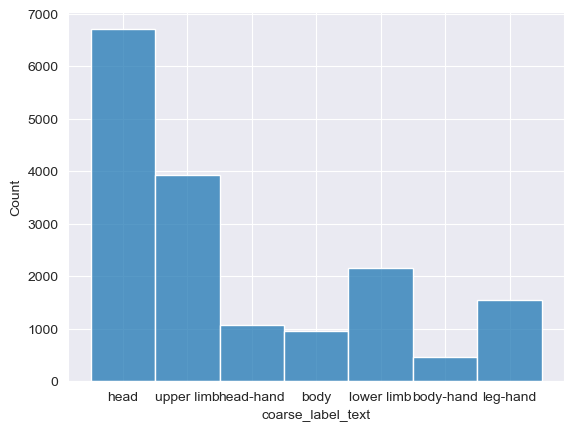

C:\Users\user\anaconda3\envs\micro\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\envs\micro\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\user\anaconda3\envs\micro\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\user\anaconda3\envs\micro\lib\site-packages\seaborn\_oldcore.py:1075:

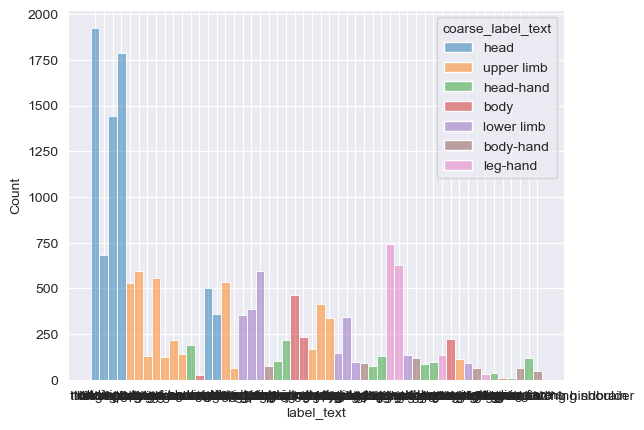

In [10]:
sns.histplot(df, x='coarse_label_text')
plt.show()
sns.histplot(df, x='label_text', hue='coarse_label_text')
plt.show()

In [11]:
# # Structure of the final dataset: filename, labels
# def get_video_list(files_folder):
#     all_files = glob(osp.join(files_folder, '*.mp4'))
#     base_names = [osp.basename(f) for f in all_files]
#     sample_id = [int(osp.splitext(f)[0].split('-')[0]) for f in base_names]
#     view = [(osp.splitext(f)[0].split('-video')[-1]) for f in base_names]
#     df = pd.DataFrame(zip(all_files, base_names, sample_id, view), columns=['filenames', 'base_name', 'sample_id', 'view'])
#     return df
# df_train_files = get_video_list(files_folder=train_files_folder)
# df_val_files = get_video_list(files_folder=val_files_folder)
# # file_sample_ids.sort()
# # file_sample_ids
# # df_train_files

In [12]:
def convert_df(df_in, multi_hot_df_in):
        
    df_out = pd.DataFrame()
    
    df_out['filenames'] = df_in['filename'].apply(lambda x: osp.basename(x))
    df_out['folder_name'] = df_in['dataset']
    # df_out['durations'] = df_in['durations']
    
    df_out['view'] = 'center'
    metadata = pd.DataFrame()
    
    
    metadata['sample_id'] = df_out['filenames'].apply(lambda x: x.split('.')[0])
    # metadata['start_frame'] = df_in['start_frame']
    # metadata['end_frame'] = df_in['end_frame']
    metadata['label_txt'] = df_in['label_text']
    metadata['label']= df_in['label']
    metadata['view'] =  df_out['view']
    metadata['filenames'] = df_out['filenames']
    # metadata['durations'] = df_out['durations']
    metadata['coarse_label'] = df_in['coarse_label']
    metadata['coarse_label_txt'] = df_in['coarse_label_text']
    # cat = df_in['label']
    # categories = list(LABEL2ID.keys())
    # one_hot_encoded = pd.get_dummies(cat.astype(pd.CategoricalDtype(categories=categories)))
    
    # new_columns = one_hot_encoded.columns.to_list()
    # one_hot_encoded = one_hot_encoded.astype(float)
    df_out['labels'] = multi_hot_df_in.values.tolist()
    # df_out['labels'] = df_in['label'] - 1
    df_out['metadata'] = metadata.to_dict(orient='records')
    
    return df_out

df_new = convert_df(df_in=df.reset_index(), multi_hot_df_in=multi_hot_df)
df_val = df_new.loc[df_new['folder_name'] == 'val']
df_train = df_new.loc[df_new['folder_name'] == 'train']

In [13]:
print(df_val.iloc[0]['labels'])
print(len(df_val.iloc[0]['labels']))

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
56


In [14]:
experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\mac'
run_name = 'mac_multi'

# os.makedirs(osp.join(experiment_folder, run_name), exist_ok=True)
# os.makedirs(osp.join(experiment_folder, run_name,'dataset'), exist_ok=True)
# 
# # df_val.to_csv(osp.join(experiment_folder,run_name,'dataset','val.csv'))
# # df_train.to_csv(osp.join(experiment_folder,run_name,'dataset','train.csv'))


In [15]:
from torch.utils.data import DataLoader
import dyadic_communication
from importlib import reload
from utils_dir import debug_model
import run_videomae_vis_v2

reload(dyadic_communication)
reload(debug_model)
reload(run_videomae_vis_v2)

from argparse import Namespace
import mpigroup.const as const


In [16]:
reload(const)
cropping_map = const.cropping_map
cropping_map

{'front1': 'tr', 'front2': 'tl', 'right': 'bl', 'left': 'br', 'center': 'mm'}

In [17]:
data_path= r'D:\Project-mpg microgesture\mac2024\track1'

args = debug_model.args
args.anno_path = osp.join(experiment_folder,run_name,'dataset','val.csv')
args.data_path = data_path
args.data_root = data_path
args.mode = 'validation'
args.test_mode = False
dataset = dyadic_communication.DyadicvideoClsDataset(
          anno_path=args.anno_path,
            data_path=args.data_path,
            mode=args.mode,
            clip_len=1,
            num_segment=args.num_frames,
            test_num_segment=args.test_num_segment,
            test_num_crop=args.test_num_crop,
            num_crop=1 if not args.test_mode else 3,
            keep_aspect_ratio=True,
            crop_size=args.input_size,
            short_side_size=args.short_side_size,
            new_height=224,
            new_width=224,
            view_crop_mapping=cropping_map,
            corner_crop_size=None,
            data_root=args.data_root,
            args=args)



In [21]:

data = DataLoader(dataset=dataset, batch_size=2, shuffle=True)
iterdata = iter(data)

In [22]:
d = next(iterdata)
print(d[0].shape)
print(d[1])
print(d[2:])

torch.Size([2, 3, 16, 224, 224])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0]], dtype=torch.int32)
[[('D:\\Project-mpg microgesture\\mac2024\\track1\\val\\0078_01_0098', 'D:\\Project-mpg microgesture\\mac2024\\track1\\val\\0078_02_0108')], ("{'sample_id': '0078_01_0098', 'label_txt': 'shaking head', 'label': 10, 'view': 'center', 'filenames': '0078_01_0098.mp4', 'coarse_label': 1, 'coarse_label_txt': 'head'}", "{'sample_id': '0078_02_0108', 'label_txt': 'illustrative gestures', 'label': 23, 'view': 'center', 'filenames': '0078_02_0108.mp4', 'coarse_label': 2, 'coarse_label_txt': 'upper limb'}"), [], []]


In [33]:
pd.DataFrame([ast.literal_eval(a) for a in d[3]])['label_txt'].values

array(['shaking head', 'illustrative gestures'], dtype=object)

In [35]:
reload(run_videomae_vis_v2)

vids = d[0]
labels = d[1]
label_txt = pd.DataFrame([ast.literal_eval(a) for a in d[3]])['label_txt'].values
fnames = pd.DataFrame([ast.literal_eval(a) for a in d[3]])['filenames'].values

for vid,label, txt_label, fname in zip(vids,labels, label_txt, fnames):
       
    # ret = get_activities(feature_names, label)

    txt =  '\n'.join([fname ,txt_label])
    
    vid = run_videomae_vis_v2.unnormalize_frames(vid)
    run_videomae_vis_v2.save_video(vid, osp.join('testing_'+fname), txt=txt)
    


In [18]:
# video_path = osp.join(path_to_root_folder,'clips_val','05942-video1.mp4')
# video_path

In [36]:
# model_dict = {
#     'experiment':'MPIG_densepose_dual_2',
#     'description':'MPIG_densepose_dual - videoMAE-K400 , same as K400 but then was finetuned on MPIGroupInteractions dataset (train set) for 100 epochs, with denspose as additional decoding target',
#     'checkpoint_path':r'D:\Project-mpg microgesture\pretrained\pretrained\MPIIGroupInteraction\k400_finetune_videomae_pretrain_dual_2_patch16_224_frame_16x4_tube_mask_ratio_0.9_e100\checkpoint-99.pth',
#     'model_name':'pretrain_videomae_base_patch16_224_densepose_dual',
# }

model_dict = {
    'experiment':'mac_multi',
    'description':'mac2024 dataset, first pretrained on mpigourpinteraction for 100 epochs then trained on mac2024 track1 dataset for 100 epochs',
    'checkpoint_path':r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments\mac_multi\checkpoint-199.pth',
    'model_name':'pretrain_videomae_base_patch16_224_densepose_dual',
}

image_batch = d[0]
save_folder = osp.join('videos')
model_path = model_dict['checkpoint_path']
model_name = model_dict['model_name']

args = Namespace(
        image_batch=image_batch,
        save_path=save_folder, # list
        model_path=model_path, 
        mask_type='tube',
        num_frames=16,
        sampling_rate=4,
        decoder_depth=4,
        input_size=224,
        device='cuda:0',
        imagenet_default_mean_and_std=True,
        mask_ratio=0,
        model=model_name,
        densepose=True,
        drop_path=0.0)

model = run_videomae_vis_v2.get_model(args=args) 

checkpoint = torch.load(args.model_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval()

Creating model: pretrain_videomae_base_patch16_224_densepose_dual


PretrainVisionTransformerMultiOutout(
  (encoder): PretrainVisionTransformerEncoder(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): Laye

In [37]:
outputs = model(image_batch)   

In [38]:
# outputs = model(image_batch) 

In [39]:
reload(run_videomae_vis_v2)

rec_videos_patches = outputs[0]
rec_densepose_patches = outputs[1]
patch_size = model.encoder.patch_embed.patch_size
unnorm_videos = run_videomae_vis_v2.unnormalize_frames(img=image_batch)
_, rec_videos, _ = run_videomae_vis_v2.reconstruct_video_from_patches(
    ori_img=unnorm_videos, patch_size=patch_size, bool_masked_pos=None, outputs=rec_videos_patches, frame_id_list=None)

_, rec_densepose, _ = run_videomae_vis_v2.reconstruct_video_from_patches(
    ori_img=unnorm_videos, patch_size=patch_size, bool_masked_pos=None, 
    outputs=rec_densepose_patches, frame_id_list=None,normalize_with_orig=False)

In [40]:
rec_densepose[0].shape

torch.Size([3, 16, 224, 224])

In [25]:
# a = (torch.nn.functional.normalize(rec_densepose[0],dim=0) + torch.Tensor([1,1,1])[:,None,None,None]) / torch.Tensor([2,2,2])[:,None,None,None]


In [26]:
# print(f'mean: {a.mean(dim=[1,2,3])}')
# print(f'std: {a.std(dim=[1,2,3])}')
# print(f'min: {a.reshape(3, -1).min(dim=1)[0]}')
# print(f'max: {a.reshape(3, -1).max(dim=1)[0] }')

In [41]:
print(f'mean: {rec_densepose[0].mean(dim=[1,2,3])}')
print(f'std: {rec_densepose[0].std(dim=[1,2,3])}')
print(f'min: {rec_densepose[0].reshape(3, -1).min(dim=1)[0]}')
print(f'max: {rec_densepose[0].reshape(3, -1).max(dim=1)[0] }')

mean: tensor([-0.0012,  0.0004,  0.0007], grad_fn=<MeanBackward1>)
std: tensor([0.2267, 0.2275, 0.2359], grad_fn=<StdBackward0>)
min: tensor([-2.2379, -2.2477, -2.0032], grad_fn=<MinBackward0>)
max: tensor([4.7746, 4.6475, 4.1586], grad_fn=<MaxBackward0>)


In [43]:
import os

vids = d[0]
labels = d[1]
label_txt = pd.DataFrame([ast.literal_eval(a) for a in d[3]])['label_txt'].values
fnames = pd.DataFrame([ast.literal_eval(a) for a in d[3]])['filenames'].values

softmax = torch.nn.Softmax(dim=0)

for ori_vid,rec_vid,rec_dense,labels,txt_label, fname in zip(vids,rec_videos,rec_densepose,labels, label_txt, fnames):
       
    txt =  '\n'.join([fname ,txt_label])

    ori_vid = run_videomae_vis_v2.unnormalize_frames(ori_vid)
    rec_dense = run_videomae_vis_v2.unnormalize_frames(rec_dense)
    # rec_dense = (torch.nn.functional.normalize(rec_dense,dim=0) + torch.Tensor([1,1,1])[:,None,None,None]) / torch.Tensor([2,2,2])[:,None,None,None]
    # rec_vid = run_videomae_vis_v2.unnormalize_frames(rec_vid)
    # rec_dense = softmax(rec_dense)

    save_folder = osp.join('videos',fname.replace('.mp4',''))
    os.makedirs(save_folder, exist_ok=True)
    
    run_videomae_vis_v2.save_video(ori_vid, osp.join(save_folder,'ori_vid_'+fname), txt=txt)

    # run_videomae_vis_v2.save_video(ori_dense, osp.join(save_folder,'ori_dense_'+fname), txt=txt)

    run_videomae_vis_v2.save_video(rec_vid, osp.join(save_folder,'rec_vid_'+fname), txt=txt)

    run_videomae_vis_v2.save_video(rec_dense, osp.join(save_folder,'rec_dense_'+fname), txt=txt)
    

In [29]:
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights_sk(y):
    # Assuming y is a multi-label array with both specific and higher-tier labels
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    print(class_weights_dict)
    

In [78]:
def get_class_weights(df,feature_names, alpha=10, beta=2, gamma=1):
    class_weights = {}
    positive_weights = {}
    negative_weights = {}
    class_frequency = {}
    # N = len(df)
    n_features = len(feature_names)

    N = np.sum(df[feature_names].to_numpy())
    for label in feature_names:
        if label in df.columns:
            positive_weights[label] = np.power(np.log((N+n_features) /(alpha * (sum(df[label] == 1))+1)*beta),gamma)
            negative_weights[label] = np.power(np.log((N+n_features) /(alpha * (sum(df[label] == 0))+1)*beta),gamma)
            
        else:
            positive_weights[label] = 0
            negative_weights[label] = 0
        
        class_frequency[label] =  sum(df[label] == 1) / N

            
    # class_weights['positive_weights'] = pd.DataFrame.from_dict(positive_weights)
    # class_weights['negative_weights'] = pd.DataFrame.from_dict(negative_weights)
    class_weights = pd.DataFrame(zip(positive_weights.keys(),class_frequency.values(), positive_weights.values(), negative_weights.values()),columns=['class','class_freq','positive_weights','negative_weights'])        
    class_weights['method'] = 'inv'
    return class_weights

def get_class_weights_regular(df,feature_names):
    class_weights = {}
    positive_weights = {}
    negative_weights = {}
    class_frequency = {}
    # N = len(df)
    n_features = len(feature_names)

    N = np.sum(df[feature_names].to_numpy())
    for label in feature_names:
        if label in df.columns:
            positive_weights[label] = np.log((N+n_features) /((sum(df[label] == 1))+1))
            negative_weights[label] = np.log((N+n_features) /((sum(df[label] == 0))+1))
            
        else:
            positive_weights[label] = 0
            negative_weights[label] = 0
        
        class_frequency[label] =  sum(df[label] == 1) / N

            
    # class_weights['positive_weights'] = pd.DataFrame.from_dict(positive_weights)
    # class_weights['negative_weights'] = pd.DataFrame.from_dict(negative_weights)
    class_weights = pd.DataFrame(zip(positive_weights.keys(),class_frequency.values(), positive_weights.values(), negative_weights.values()),columns=['class','class_freq','positive_weights','negative_weights'])        
    class_weights['method'] = 'regular'
    return class_weights



In [79]:
multi_hot_df.columns

Index(['shaking body', 'sitting straightly', 'shrugging', 'turning around',
       'rising up', 'bowing head', 'head up', 'tilting head', 'turning head',
       'nodding', 'shaking head', 'scratching arms', 'playing objects',
       'putting hands together', 'rubbing hands', 'pointing oneself',
       'clenching fist', 'stretching arms', 'retracting arms', 'waving',
       'spreading hands', 'hands touching fingers', 'other finger movements',
       'illustrative gestures', 'shaking legs', 'curling legs', 'spread legs',
       'closing legs', 'crossing legs', 'stretching feet', 'retracting feet',
       'tiptoe', 'scratching or touching neck', 'scratching or touching chest',
       'scratching or touching back', 'scratching or touching shoulder',
       'arms akimbo', 'crossing arms', 'playing or tidying hair',
       'scratching or touching hindbrain', 'scratching or touching forehead',
       'scratching or touching face', 'rubbing eyes', 'touching nose',
       'touching ears', 'cov

In [82]:
# df = train_one_hot_encoded
feature_names = multi_hot_df.columns

class_weights =  get_class_weights(multi_hot_df,feature_names, alpha=3, beta=1, gamma=1.2)
# class_weights = get_class_weights_regular(multi_hot_df,feature_names)
class_weights

C:\Users\user\AppData\Local\Temp\ipykernel_32380\3422413943.py:13: RuntimeWarning: invalid value encountered in power
  negative_weights[label] = np.power(np.log((N+n_features) /(alpha * (sum(df[label] == 0))+1)*beta),gamma)


,class,class_freq,positive_weights,negative_weights,method
0,shaking body,0.012570,4.157523,NaN,inv
1,sitting straightly,0.006094,5.280892,NaN,inv
2,shrugging,0.000789,8.648039,NaN,inv
3,turning around,0.000326,10.158225,NaN,inv
4,rising up,0.006312,5.225453,NaN,inv
5,bowing head,0.013740,4.022567,NaN,inv
6,head up,0.009876,4.526836,NaN,inv
7,tilting head,0.018610,3.568165,NaN,inv
8,turning head,0.039233,2.492993,NaN,inv
9,nodding,0.052347,2.095749,NaN,inv


<Axes: xlabel='class_freq', ylabel='positive_weights'>

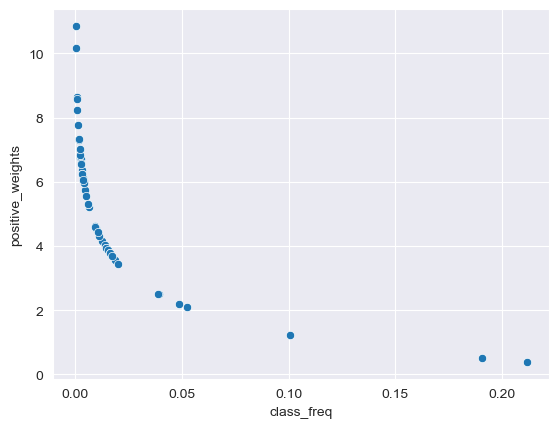

In [83]:
sns.scatterplot(data=class_weights, x='class_freq', y='positive_weights')#, hue='class')

In [49]:
from sklearn.utils.class_weight import compute_class_weight
df = df_train_raw
labels = df['label'].values
classes = df['label'].unique()
class_weights_vals = compute_class_weight(class_weight="balanced", classes=classes, y=labels)
# compute_class_weight()
class_weights = pd.DataFrame(zip(classes, class_weights_vals), columns=['class', 'positive_weights'])
class_weights.sort_values(by='class', inplace=True)
class_weights

In [84]:
# import pandas as pd
# import os.path as osp
# import ast
# from collections import Counter
# df_del = pd.read_csv(osp.join(r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg\videomae_vit_base_patch16_224_kinetic_400_densepose_dual\dataset','train.csv'))
# 
# df_del['label_text'] = df_del['metadata'].apply(lambda x: ast.literal_eval(x)['label_txt'])
# pd.DataFrame.from_dict({'count':Counter(df_del['label_text'])}).to_clipboard()

In [86]:
# from itertools import Counter

In [87]:
# save_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg\videomae_vit_base_patch16_224_kinetic_400_densepose_dual_multi\dataset'
# save_folder = osp.join(*save_folder.split('/'))
save_folder = osp.join(experiment_folder, run_name, 'dataset')

os.makedirs(save_folder, exist_ok=True)

df_train.to_csv(osp.join(save_folder, 'train.csv'))
# df_test.to_csv(osp.join(save_folder, 'test.csv'))
df_val.to_csv(osp.join(save_folder, 'val.csv'))
class_weights.to_csv(osp.join(save_folder, 'weights.csv'))

In [88]:

import json
wrapped_data = {'data': class_weights.to_dict(orient='records')}

# Save wrapped data as JSON
with open(osp.join(save_folder, 'weights.json'), 'w') as json_file:
    json.dump(wrapped_data, json_file, indent=4)

In [89]:
len(class_weights)

56